<a href="https://colab.research.google.com/github/ANIRVANJENA/ANIRVANJENA/blob/main/Statistical_Arbitrage_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Define the list of stock symbols
stocks = ['RELIANCE.NS', 'TCS.NS', 'INFY.NS', 'HDFCBANK.NS']

# Fetch the historical data for the defined stocks
data = yf.download(stocks, start='2010-01-01', end='2024-01-01')['Adj Close']

# Fill missing values
data.fillna(method='ffill', inplace=True)


[*********************100%%**********************]  4 of 4 completed


In [ ]:
# Calculate daily returns
returns = data.pct_change().dropna()

# Normalize the data
normalized_data = (data - data.mean()) / data.std()

# Generate all possible pairs of stocks
pairs = [(stocks[i], stocks[j]) for i in range(len(stocks)) for j in range(i+1, len(stocks))]


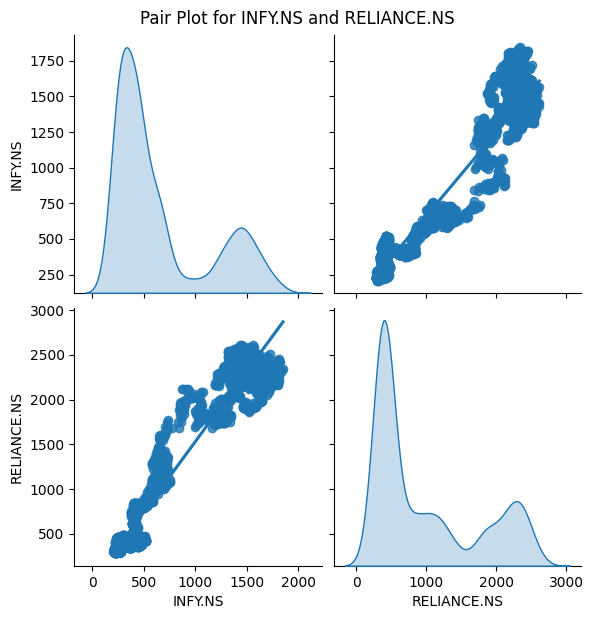

In [ ]:
import seaborn as sns


pair = cointegrated_pairs[0]

# Create pair plot for cointegrated pairs
sns.pairplot(data[[pair[0], pair[1]]], kind='reg', diag_kind='kde', height=3)
plt.suptitle(f'Pair Plot for {pair[0]} and {pair[1]}', y=1.02)
plt.show()


In [ ]:
from statsmodels.tsa.stattools import coint

# Function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.columns
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            stock1 = data[keys[i]]
            stock2 = data[keys[j]]
            score, pvalue, _ = coint(stock1, stock2)
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:  # Typically a p-value threshold of 0.05 is used
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

pvalue_matrix, cointegrated_pairs = find_cointegrated_pairs(data)
print("Cointegrated pairs:", cointegrated_pairs)


Cointegrated pairs: [('INFY.NS', 'RELIANCE.NS'), ('RELIANCE.NS', 'TCS.NS')]


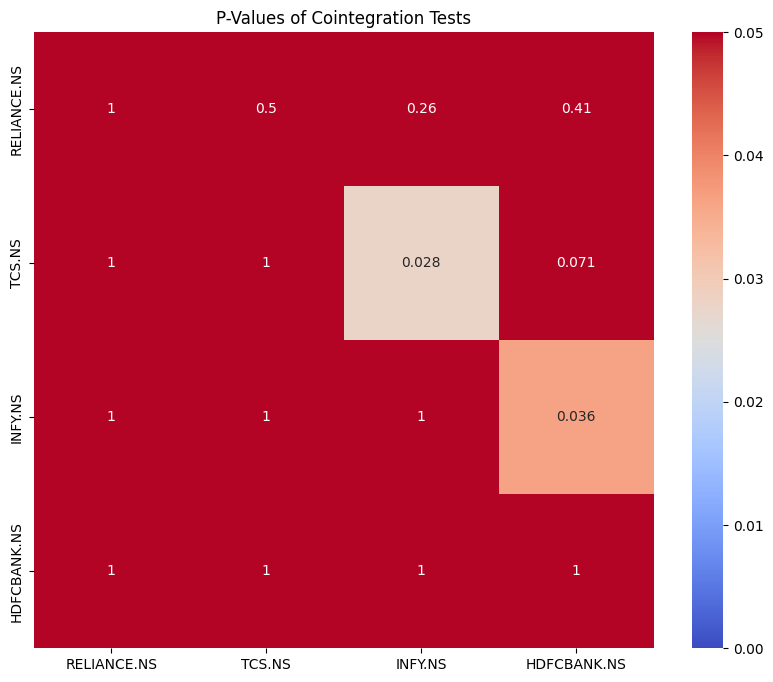

In [ ]:
# Plot heatmap of p-values
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(pvalue_matrix, xticklabels=stocks, yticklabels=stocks, annot=True, cmap='coolwarm', vmin=0, vmax=0.05)
plt.title('P-Values of Cointegration Tests')
plt.show()


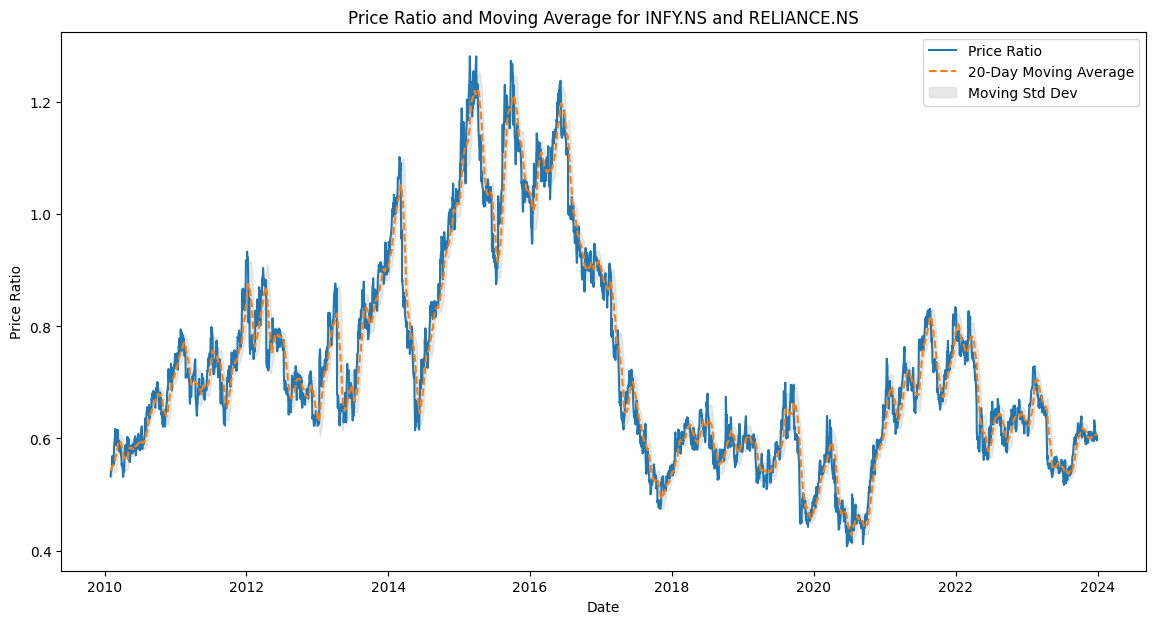

In [ ]:
# Example pair
pair = cointegrated_pairs[0]

# Generate features for the pair
features = create_features(data, pair)

# Plot the price ratio and moving averages
plt.figure(figsize=(14, 7))
plt.plot(features['ratio'], label='Price Ratio')
plt.plot(features['moving_avg'], label='20-Day Moving Average', linestyle='--')
plt.fill_between(features.index, features['moving_avg'] - features['moving_std'], features['moving_avg'] + features['moving_std'], color='lightgrey', alpha=0.5, label='Moving Std Dev')
plt.title(f'Price Ratio and Moving Average for {pair[0]} and {pair[1]}')
plt.xlabel('Date')
plt.ylabel('Price Ratio')
plt.legend(loc='best')
plt.show()


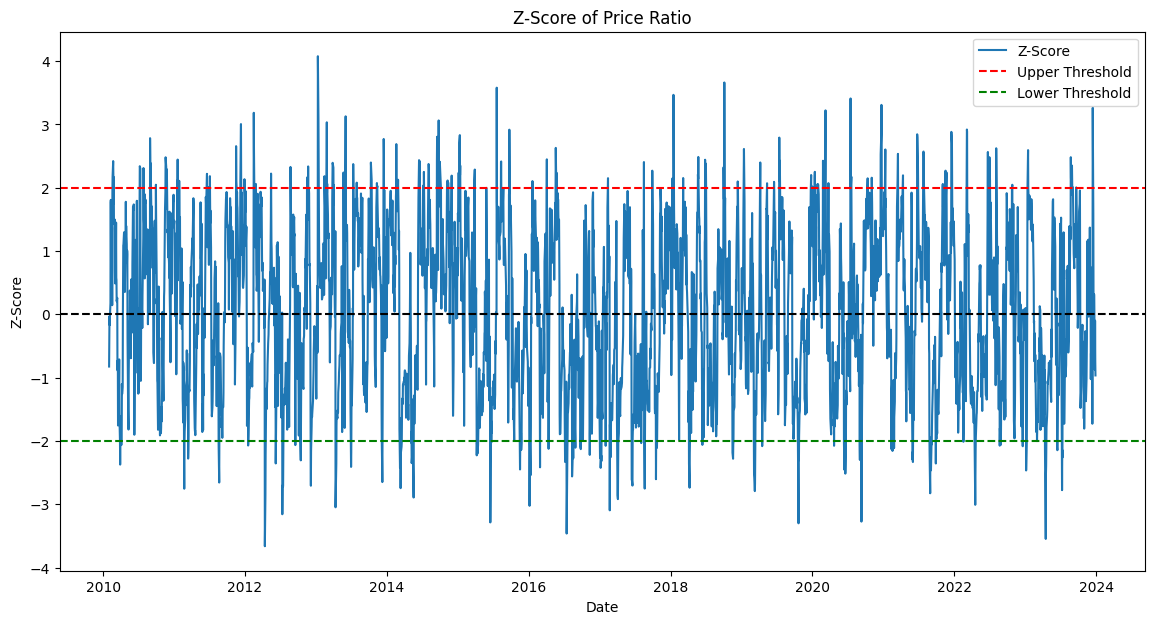

In [ ]:
# Plot the z-score
plt.figure(figsize=(14, 7))
plt.plot(features['z_score'], label='Z-Score')
plt.axhline(2, color='red', linestyle='--', label='Upper Threshold')
plt.axhline(-2, color='green', linestyle='--', label='Lower Threshold')
plt.axhline(0, color='black', linestyle='--')
plt.title('Z-Score of Price Ratio')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend(loc='best')
plt.show()




In [ ]:
def create_features(data, pair):
    stock1, stock2 = pair
    ratio = data[stock1] / data[stock2]
    moving_avg = ratio.rolling(window=20).mean()
    moving_std = ratio.rolling(window=20).std()
    z_score = (ratio - moving_avg) / moving_std
    return pd.DataFrame({
        'ratio': ratio,
        'moving_avg': moving_avg,
        'moving_std': moving_std,
        'z_score': z_score
    }).dropna()

features = create_features(data, cointegrated_pairs[0])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define the target
features['target'] = np.where(features['z_score'] > 2, 1, 0)  # 1: Short, 0: Neutral/Long

# Split the data into training and testing sets
X = features[['ratio', 'moving_avg', 'moving_std', 'z_score']]
y = features['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       652
           1       1.00      1.00      1.00        35

    accuracy                           1.00       687
   macro avg       1.00      1.00      1.00       687
weighted avg       1.00      1.00      1.00       687



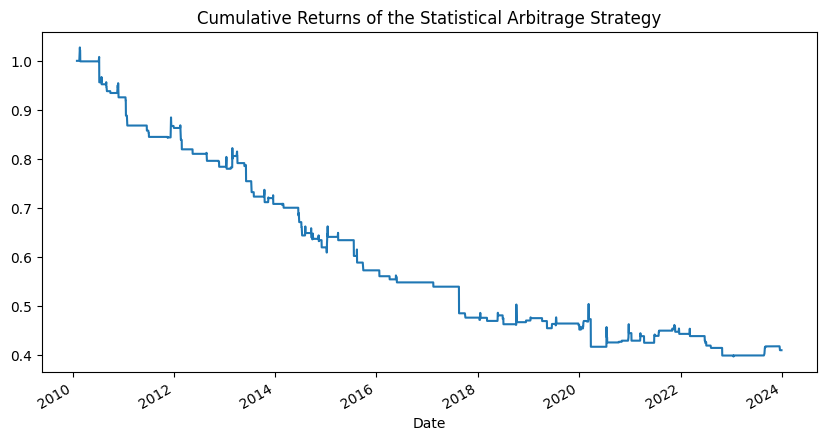

In [ ]:
# Backtest function
def backtest(data, pair, model):
    stock1, stock2 = pair
    features = create_features(data, pair)
    X = features[['ratio', 'moving_avg', 'moving_std', 'z_score']]
    features['predicted'] = model.predict(X)

    signals = features['predicted']
    stock1_returns = data[stock1].pct_change()
    stock2_returns = data[stock2].pct_change()

    strategy_returns = signals.shift(1) * (stock1_returns - stock2_returns)
    cumulative_returns = (1 + strategy_returns).cumprod()

    return cumulative_returns

# Evaluate the strategy on the test set
cumulative_returns = backtest(data, cointegrated_pairs[0], model)
cumulative_returns.plot(figsize=(10, 5))
plt.title('Cumulative Returns of the Statistical Arbitrage Strategy')
plt.show()
